In [2]:
import numpy as np
from scipy.interpolate import BSpline
from scipy.linalg import eigh
from scipy.integrate import simpson
import matplotlib.pyplot as plt
from scipy.special import assoc_laguerre, factorial

[ 0.          0.          0.          0.          0.          0.5
  1.          1.5         2.          2.5         3.          3.5
  4.          4.5         5.          5.82648088  6.88770334  8.25033996
 10.         10.         10.         10.         10.        ]


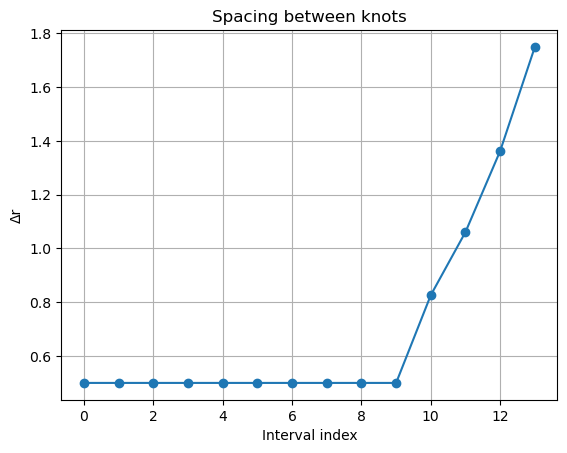

Norm of B_matrix with nquad=3: 1.419606
Norm of B_matrix with nquad=5: 1.420258
Norm of B_matrix with nquad=7: 1.420258
Norm of B_matrix with nquad=10: 1.420258


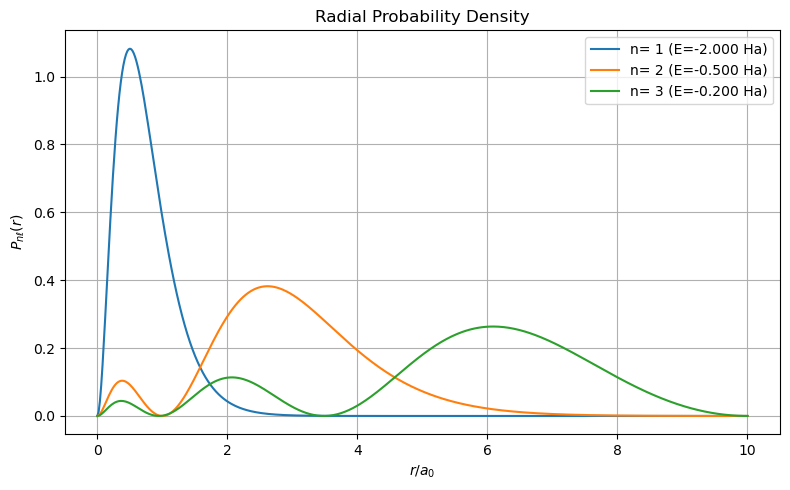

Normalization = 1.00000
n = 1:  E_numerical = -1.999984 Ha,  E_analytical = -2.000000 Ha,  ΔE = 1.62e-05 Ha
n = 2:  E_numerical = -0.499948 Ha,  E_analytical = -0.500000 Ha,  ΔE = 5.21e-05 Ha
n = 3:  E_numerical = -0.199672 Ha,  E_analytical = -0.222222 Ha,  ΔE = 2.26e-02 Ha


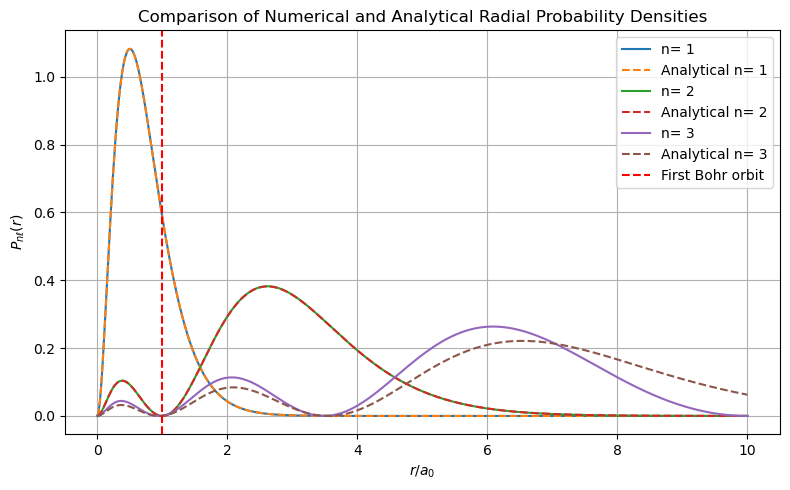

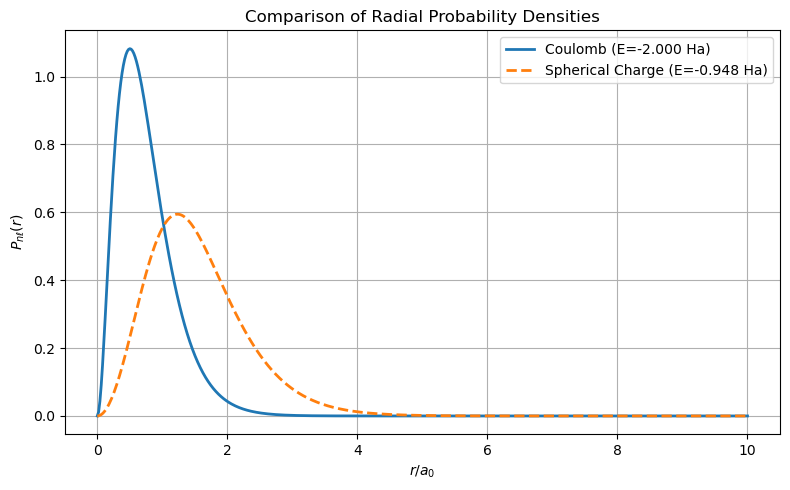

In [3]:
def knotssq(a, b, N_linear, N_nonuniform, transition, scheme):
    linear_knots = np.linspace(a, transition, N_linear, endpoint=False)
    
    if scheme == 'exponential':
        s = np.linspace(0, 1, N_nonuniform)
        nonuniform_knots = transition + (b - transition) * (np.exp(s) - 1) / (np.e - 1)
    elif scheme == 'quadratic':
        s = np.linspace(0, 1, N_nonuniform)
        nonuniform_knots = transition + (b - transition) * s**2
    elif scheme == 'linear':
        nonuniform_knots = np.linspace(transition, b, N_nonuniform)
    
    return np.concatenate((linear_knots, nonuniform_knots))

a, b = 0.0, 10.0
transition = 5.0  
N_linear = 10    
N_nonuniform = 5 

#nknots = 5 
#knots = np.linspace(a, b, nknots)
knots = knotssq(a, b, N_linear, N_nonuniform, transition, scheme='exponential')
degree = 4        
augmented_knots = np.concatenate((np.repeat(knots[0], degree), knots, np.repeat(knots[-1], degree)))
print(augmented_knots)
n_basis = len(augmented_knots) - degree - 1
collocation_pts = knots  

plt.plot(np.diff(knots), marker='o')
plt.title("Spacing between knots")
plt.xlabel("Interval index")
plt.ylabel("Δr")
plt.grid(True)
plt.show()


def B(augmented_knots, degree, n_basis, nquad):
    unique_knots = collocation_pts
    B_matrix = np.zeros((n_basis, n_basis))
    
    for i_int in range(len(unique_knots) - 1):
        a_int = unique_knots[i_int]
        b_int = unique_knots[i_int + 1]
        if np.isclose(b_int, a_int):
            continue
        
        x_quad, w_quad = np.polynomial.legendre.leggauss(nquad)
        x_mapped = 0.5 * (b_int - a_int) * x_quad + 0.5 * (b_int + a_int)
        w_mapped = 0.5 * (b_int - a_int) * w_quad
        
        B_vals = np.zeros((n_basis, len(x_mapped)))
        for i in range(n_basis):
            coeffs = np.zeros(n_basis)
            coeffs[i] = 1.0
            spline = BSpline(augmented_knots, coeffs, degree, extrapolate=False)
            B_vals[i, :] = spline(x_mapped)
    
        for i in range(n_basis):
            for j in range(i, n_basis):
                integrand = B_vals[i, :] * B_vals[j, :]
                integral_value = np.sum(w_mapped * integrand)
                B_matrix[i, j] += integral_value
                if i != j:
                    B_matrix[j, i] += integral_value
    return B_matrix

B_matrix = B(augmented_knots, degree, n_basis, nquad=5)

nquads = [3, 5, 7, 10]
for nq in nquads:
    B_matrix = B(augmented_knots, degree, n_basis, nquad=nq)
    print(f"Norm of B_matrix with nquad={nq}: {np.linalg.norm(B_matrix):.6f}")

def spherical_potential(r, Z, R0):
    return np.where(r < R0, -Z * ((3.0/(2*R0)) - (r**2)/(2*R0**3)), -Z / r)

def H(augmented_knots, degree, n_basis, nquad, l, Z, R0=None):
    unique_knots = collocation_pts
    H_matrix = np.zeros((n_basis, n_basis))
    
    for i_int in range(len(unique_knots) - 1):
        t_start = unique_knots[i_int]
        t_end = unique_knots[i_int + 1]
        if np.isclose(t_end, t_start):
            continue
        
        x_quad, w_quad = np.polynomial.legendre.leggauss(nquad)
        x_mapped = 0.5 * (t_end - t_start) * x_quad + 0.5 * (t_end + t_start)
        w_mapped = 0.5 * (t_end - t_start) * w_quad
        
        B_vals = np.zeros((n_basis, len(x_mapped)))
        B_der_vals = np.zeros((n_basis, len(x_mapped)))
        for i in range(n_basis):
            coeffs = np.zeros(n_basis)
            coeffs[i] = 1.0
            spline = BSpline(augmented_knots, coeffs, degree, extrapolate=False)
            B_vals[i, :] = spline(x_mapped)
            B_der_vals[i, :] = spline.derivative(nu=1)(x_mapped)
        
        if R0 is not None:
            V_nuclear = spherical_potential(x_mapped, Z, R0)
        else:
            V_nuclear = -Z / x_mapped
        
        V_eff = V_nuclear + (l * (l + 1)) / (2.0 * x_mapped**2)
        
        for i in range(n_basis):
            for j in range(i, n_basis):
                kinetic_integrand = 0.5 * B_der_vals[i, :] * B_der_vals[j, :]
                potential_integrand = V_eff * B_vals[i, :] * B_vals[j, :]
                integral_value = np.sum(w_mapped * (kinetic_integrand + potential_integrand))
                H_matrix[i, j] += integral_value
                if i != j:
                    H_matrix[j, i] += integral_value
    return H_matrix

l = 0     
Z = 2   
A = 238
R0_fm = 1.2 * A**(1/3)    
R0_au = R0_fm / 5.29e4    
Z_U = 92
H_matrix_uranium = H(augmented_knots, degree, n_basis, nquad=5, l=l, Z=Z_U, R0=R0_au)
H_matrix_spherical = H(augmented_knots, degree, n_basis, nquad=5, l=l, Z=Z, R0=1.5)
H_matrix = H(augmented_knots, degree, n_basis, nquad=5, l=l, Z=Z, R0=None)

B_reduced = B_matrix[1:-1, 1:-1]
H_reduced = H_matrix[1:-1, 1:-1]

eigenvalues, eigenvectors = eigh(H_reduced, B_reduced)

n_basis_full = B_matrix.shape[0]
c_full = np.zeros((n_basis_full, eigenvectors.shape[1]))
c_full[1:-1, :] = eigenvectors  

r_vals = np.linspace(a, b, 500)
num_to_plot = 3

#Plot
plt.figure(figsize=(8, 5))
for i in range(num_to_plot):
    phi_spline = BSpline(augmented_knots, c_full[:, i], degree, extrapolate=False)
    P_vals = phi_spline(r_vals)
    plt.plot(r_vals, P_vals**2, label=f'n= {i+1} (E={eigenvalues[i]:.3f} Ha)')
#plt.axvline(x=1, color='r', linestyle='--', label="First Bohr orbit")
plt.xlabel(r'$r/a_0$')
plt.ylabel(r'$P_{n\ell}(r)$')
plt.title('Radial Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

integral = simpson(P_vals**2, r_vals)
print(f'Normalization = {integral:.5f}')

def analytical_radial(n, l, r, Z=1):
    N = np.sqrt((2.0*Z/n)**3 * factorial(n-l-1) / (2*n * factorial(n+l)))
    arg = 2 * Z * r / n
    L = assoc_laguerre(arg, n - l - 1, 2*l + 1)
    Rnl = N * np.exp(-Z * r / n) * (arg)**l * L
    return r * Rnl 


plt.figure(figsize=(8, 5))
for i in range(num_to_plot):
    n_quantum = i+1
    
    E_analytical = -Z**2 / (2.0 * n_quantum**2)
    
    phi_spline = BSpline(augmented_knots, c_full[:, i], degree, extrapolate=False)
    phi_num = phi_spline(r_vals)
    norm_num = np.sqrt(simpson(phi_num**2, r_vals))
    if norm_num != 0:
        phi_num = phi_num / norm_num

    phi_ana = analytical_radial(n_quantum, l, r_vals, Z=Z)
    norm_ana = np.sqrt(simpson(phi_ana**2, r_vals))
    if norm_ana != 0:
        phi_ana = phi_ana / norm_ana

    if np.dot(phi_num, phi_ana) < 0:
        phi_num = -phi_num
    
    eigen_error = np.abs(eigenvalues[i] - E_analytical)
    print(f"n = {n_quantum}:  E_numerical = {eigenvalues[i]:.6f} Ha,  E_analytical = {E_analytical:.6f} Ha,  ΔE = {eigen_error:.2e} Ha")
    
    plt.plot(r_vals, phi_num**2, label=f'n= {n_quantum}')
    plt.plot(r_vals, phi_ana**2, '--', label=f'Analytical n= {n_quantum}')
plt.axvline(x=1, color='r', linestyle='--', label="First Bohr orbit")
plt.xlabel(r'$r/a_0$')
plt.ylabel(r'$P_{n\ell}(r)$')
plt.title('Comparison of Numerical and Analytical Radial Probability Densities')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Coulomb 
H_matrix_point = H(augmented_knots, degree, n_basis, nquad=5, l=l, Z=Z, R0=None)
H_reduced_point = H_matrix_point[1:-1, 1:-1]
eigenvalues_point, eigenvectors_point = eigh(H_reduced_point, B_reduced)

# Spherical
H_matrix_extended = H(augmented_knots, degree, n_basis, nquad=5, l=l, Z=Z, R0=1.5)
H_reduced_extended = H_matrix_extended[1:-1, 1:-1]
eigenvalues_extended, eigenvectors_extended = eigh(H_reduced_extended, B_reduced)

# Coulomb
c_full_point = np.zeros((B_matrix.shape[0], eigenvectors_point.shape[1]))
c_full_point[1:-1, :] = eigenvectors_point

# Spherical
c_full_extended = np.zeros((B_matrix.shape[0], eigenvectors_extended.shape[1]))
c_full_extended[1:-1, :] = eigenvectors_extended

plt.figure(figsize=(8, 5))
phi_spline_point = BSpline(augmented_knots, c_full_point[:, 0], degree, extrapolate=False)
phi_point = phi_spline_point(r_vals)
phi_spline_extended = BSpline(augmented_knots, c_full_extended[:, 0], degree, extrapolate=False)
phi_extended = phi_spline_extended(r_vals)

plt.plot(r_vals, phi_point**2, label=f'Coulomb (E={eigenvalues_point[0]:.3f} Ha)', lw=2)
plt.plot(r_vals, phi_extended**2, '--', label=f'Spherical Charge (E={eigenvalues_extended[0]:.3f} Ha)', lw=2)
plt.xlabel(r'$r/a_0$')
plt.ylabel(r'$P_{n\ell}(r)$')
plt.title('Comparison of Radial Probability Densities')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

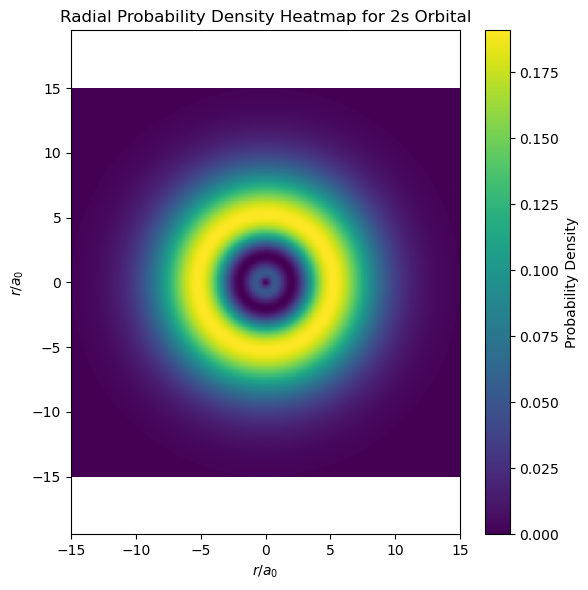

In [ ]:
b=15
r_vals = np.linspace(0, b, 500)

x = np.linspace(-b, b, 500)
y = np.linspace(-b, b, 500)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

phi_spline = BSpline(augmented_knots, c_full[:, 1], degree, extrapolate=False)
phi_r = phi_spline(r_vals)

from scipy.interpolate import interp1d
phi_interp = interp1d(r_vals, phi_r, bounds_error=False, fill_value=0)
phi_2d = phi_interp(R)

prob_density = phi_2d**2
plt.figure(figsize=(6, 6))
plt.pcolormesh(X, Y, prob_density, shading='auto', cmap='viridis')
plt.colorbar(label='Probability Density')
#plt.plot([0.25, 1.25], [0.0, 0.0], linestyle='--', color='red', linewidth=1.5)
plt.xlabel(r'$r/a_0$')
plt.ylabel(r'$r/a_0$')
plt.title('Radial Probability Density Heatmap for 2s Orbital')
plt.axis('equal')
plt.tight_layout()
plt.show()

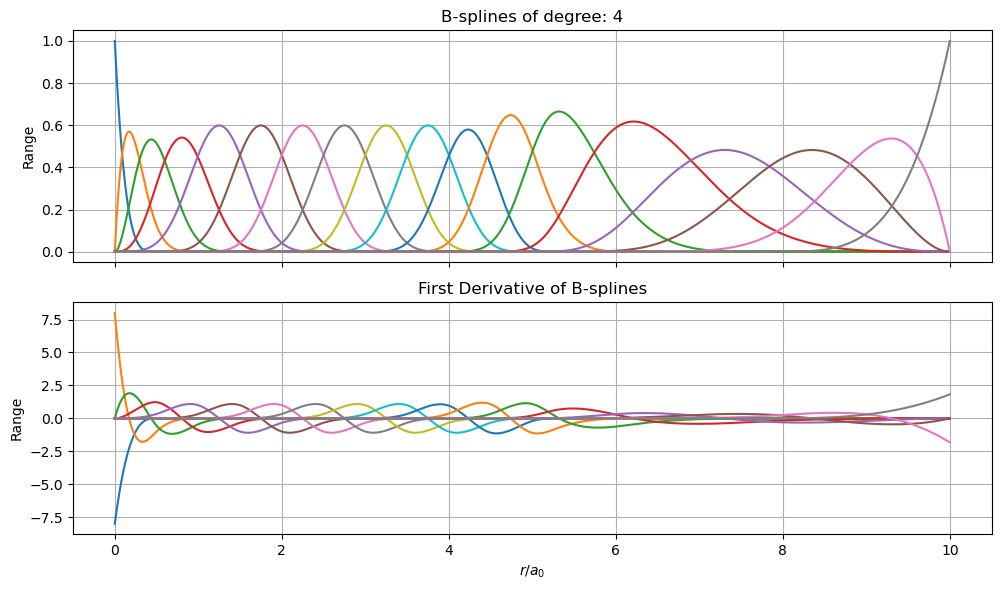

In [103]:
# Plot B-splines:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

r_fine = np.linspace(a, b, 1000)

for j in range(n_basis):
    coeffs = np.zeros(n_basis)
    coeffs[j] = 1
    B_j = BSpline(augmented_knots, coeffs, degree)
    ax[0].plot(r_fine, B_j(r_fine))  
ax[0].set_ylabel('Range')
ax[0].set_title(f'B-splines of degree: {degree}')
ax[0].grid()

for j in range(n_basis):
    coeffs = np.zeros(n_basis)
    coeffs[j] = 1
    B_j_dd = BSpline(augmented_knots, coeffs, degree).derivative(nu=1)
    ax[1].plot(r_fine, B_j_dd(r_fine))
ax[1].set_ylabel("Range")
ax[1].set_xlabel(r'$r/a_0$')
ax[1].set_title('First Derivative of B-splines')
ax[1].grid()


plt.tight_layout()
plt.show()